In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Data location
# datdir = "/projects/p31512/aeh581/gexpParPCA/out2"
datdir = "./data/out2"

In [3]:
# Directory structure
pcadir = f"{datdir}/pca"
eigdir = f"{datdir}/pca/eig"
gnames_fname = f"./data/gene_names.txt"

In [4]:
with open(f"{pcadir}/binsize.txt", 'r') as f:
    bin_size = int(f.read())
    
with open(f"{pcadir}/nboot.txt", 'r') as f:
    nboot = int(f.read())
    
with open(f"{pcadir}/nsamp.txt", 'r') as f:
    nsamp = int(f.read())
    
bin_psts = np.load(f"{pcadir}/bin_psts.npy")

gnames = np.genfromtxt(gnames_fname, dtype=str)

In [5]:
# Load data
evals_data = np.load(f"{eigdir}/dat_eval.npy")
evecs_data = np.load(f"{eigdir}/dat_evec.npy")

nbins, npca = evals_data.shape
ngenes = evecs_data.shape[2]

print(f"nbins: {nbins}")
print(f"npca: {npca}")
print(f"ngenes: {ngenes}")
print(f"nboot: {nboot}")
print(f"nsamp: {nsamp}")

nbins: 121
npca: 3
ngenes: 25289
nboot: 20
nsamp: 20


In [6]:
# Load bootstrap and nulls
evals_boot = np.zeros([nbins, nboot, npca])
evals_null = np.zeros([nbins, nboot, npca])
for i in range(nbins):
    evals_boot[i] = np.load(f"{eigdir}/boot_eval_t{i}.npy")
    evals_null[i] = np.load(f"{eigdir}/shuf_eval_t{i}.npy")
    

In [7]:
expvar_data = evals_data / np.sum(evals_data, axis=1)[:,None]
expvar_boot = evals_boot / np.sum(evals_boot, axis=2)[:,:,None]
expvar_null = evals_null / np.sum(evals_null, axis=2)[:,:,None]

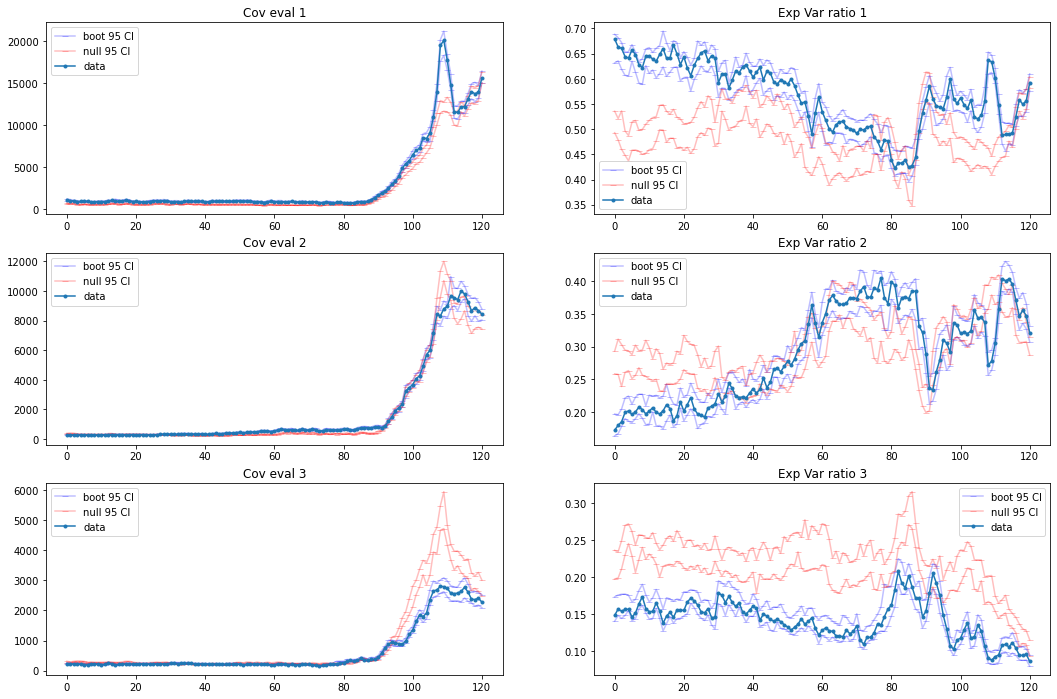

In [8]:
k = npca
fig, axes = plt.subplots(k, 2, figsize=(18,12))

for i in range(k):
    ax = axes[i][0]
    plotter = ax.plot
    plotter(np.percentile(evals_boot[:,:,i], 97.5, axis=1), 'b', alpha=0.25, marker='_', label='boot 95 CI');
    plotter(np.percentile(evals_boot[:,:,i], 2.5, axis=1), 'b', alpha=0.25, marker='_');
    plotter(np.percentile(evals_null[:,:,i], 97.5, axis=1), 'r', alpha=0.25, marker='_', label='null 95 CI');
    plotter(np.percentile(evals_null[:,:,i], 2.5, axis=1), 'r', alpha=0.25, marker='_');
    plotter(evals_data[:,i], marker='.', label='data')
    ax.set_title(f"Cov eval {i+1}")
    ax.legend()
    
for i in range(k):
    ax = axes[i][1]
    ax.plot(np.percentile(expvar_boot[:,:,i], 97.5, axis=1), 'b', alpha=0.25, marker='_', label='boot 95 CI');
    ax.plot(np.percentile(expvar_boot[:,:,i], 2.5, axis=1), 'b', alpha=0.25, marker='_');
    ax.plot(np.percentile(expvar_null[:,:,i], 97.5, axis=1), 'r', alpha=0.25, marker='_', label='null 95 CI');
    ax.plot(np.percentile(expvar_null[:,:,i], 2.5, axis=1), 'r', alpha=0.25, marker='_');
    ax.plot(expvar_data[:,i], marker='.', label='data')
    ax.set_title(f"Exp Var ratio {i+1}")
    ax.legend()


In [9]:
# Location of maximum eigenvalue 1
max_idx = np.argmax(evals_data[:,0])
print(f"Max Eval Index: {max_idx}")

Max Eval Index: 109


In [10]:
primary_evecs = evecs_data[max_idx]
primary_evec_1 = primary_evecs[0]

In [11]:
print(np.min(primary_evec_1))
print(np.max(primary_evec_1))

-0.6219974111094271
0.3709569554302564


In [14]:
k = 10
eps = 0.001

idx_subset = list(range(max_idx - k, max_idx + k + 1))
evec_subset = evecs_data[idx_subset, 0, :]

interesting_gene_idxs = np.unique(np.where(evec_subset**2 > eps)[1])
interesting_gene_names = gnames[interesting_gene_idxs]
num_int_genes = len(interesting_gene_idxs)

print(interesting_gene_idxs)
print(interesting_gene_names)
print(num_int_genes)

gene_data = np.zeros([num_int_genes+1, 2*k+1])
for i, idx in enumerate(range(max_idx-k, max_idx+k+1)):
    evec = evecs_data[idx, 0]
    gene_data[:-1,i] = evec[interesting_gene_idxs]**2
    gene_data[-1,i] = 1 - np.sum(gene_data[:-1,i])

[ 3974  4275  5596  7786 13923 14293 15755 18864 20076 20078 20079 25279]
['Camp' 'Ccl6' 'Cybb' 'Fth1' 'Lcn2' 'Ltf' 'Ngp' 'Psap' 'S100a6' 'S100a8'
 'S100a9' 'mt-Co2']
12


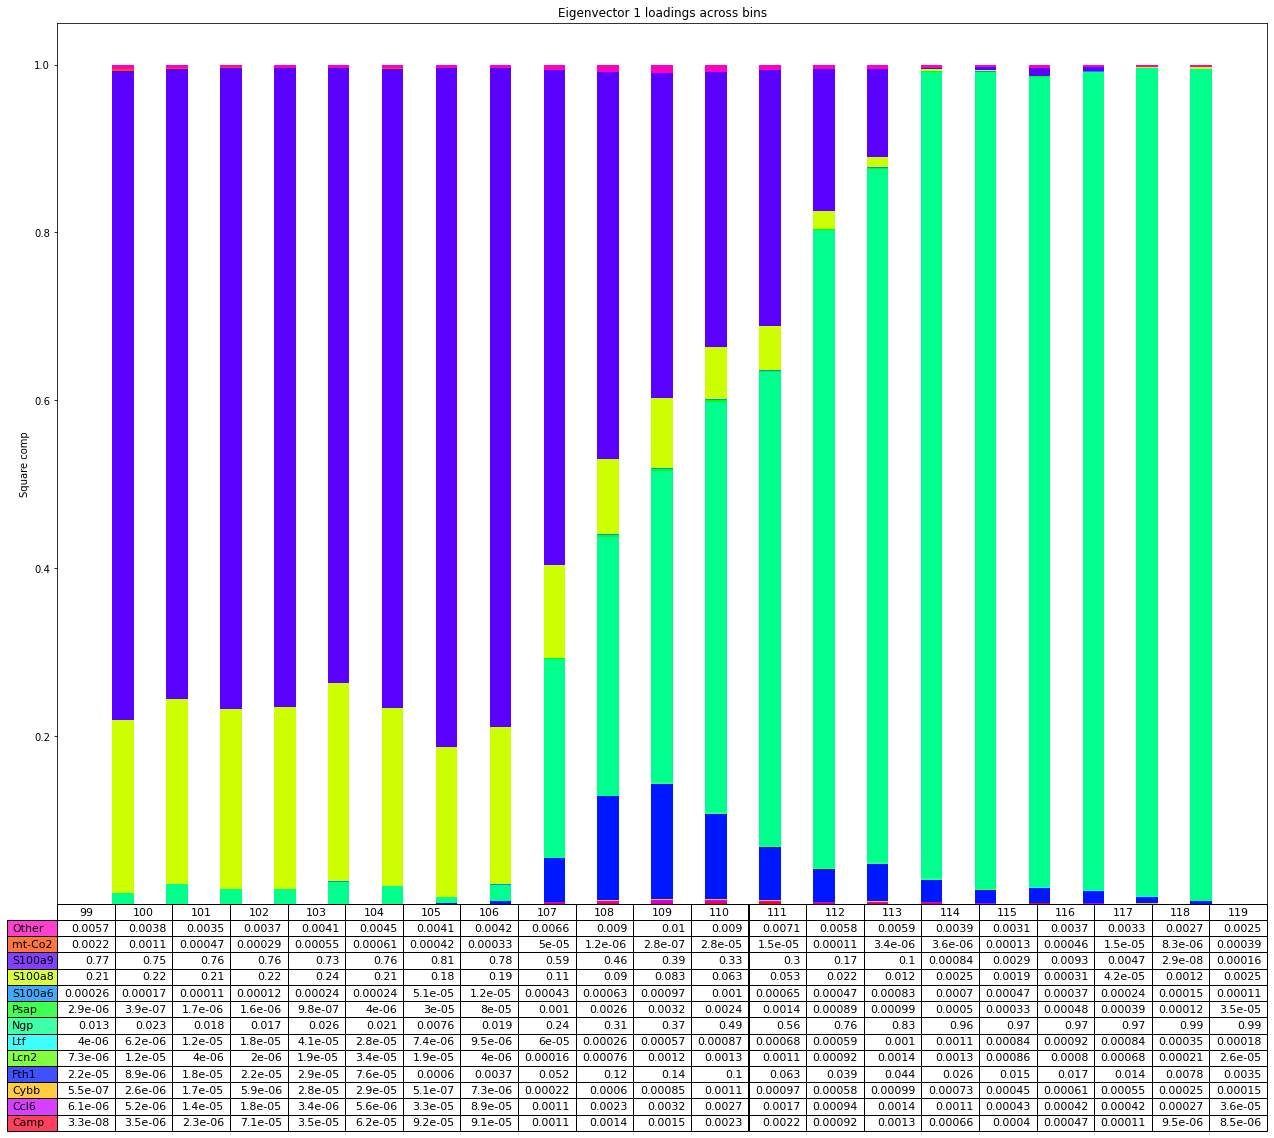

In [20]:
data = gene_data
columns = idx_subset
rows = list(interesting_gene_names) + ['Other']

# Get colors
colors = plt.cm.gist_rainbow(np.linspace(0, 1, len(rows)))
colors[1::2,:] = np.flip(colors[1::2,:], axis=0)

n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

fig, ax = plt.subplots(1, 1, figsize=(24,18))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    ax.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append([f'{x:.2g}' for x in data[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()
rows.reverse()

# Add a table at the bottom of the axes
the_table = ax.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=[[*r[0:-1], 0.75] for r in colors],
                      colLabels=columns,
                      loc='bottom', 
                    )

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

ax.set_ylabel("Square comp")
ax.set_xticks([])
ax.set_title('Eigenvector 1 loadings across bins')
the_table.set_fontsize(32)
the_table.scale(1, 1.5)

plt.show()
